## Script para estimar elasticidad de la demanda - Versión Optimizada

### Librerias necesarias para realizar los procesos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from src.dynamic_pricing_data_loader import cargar_y_preparar_datos, calcular_kpis_y_clasificar
from src.data_visualizer import year_day_hour_plot, day_hour_plot, advance_sales_plot, pieplot
from src.elasticity_calculator import ejecutar_modelo
from src.kpis_calculator import ventas_x_dia_hora

### Cargar y preparar datos

In [2]:
# Definir rutas
ruta_principal = os.getcwd()
config_path = os.path.join(ruta_principal, "config", "config.json")

# Cargar y preparar datos
df_final = cargar_y_preparar_datos(config_path, ruta_principal)

display(df_final.head())
df_final.describe()

Memoria usada antes: 686.64 MB
Memoria usada después: 127.11 MB
Reducción: 81.5%


,OPERACION,TRANSACCION,FECHA_OPERACION,HORA_OPERACION,NOMBRE_DIA_OPERACION,AREA_VENTA,CLASE_SERVICIO,ORIGEN,DESTINO,CV_CORRIDA,...,PAGO_METODO,TOTAL_BOLETOS,TOTAL_VENTA,DIF_TARIF,HORA_DECIMAL,AÑO,MES,DIAS_ANTICIPACION,HORAS_ANTICIPACION,TIEMPO_ANTICIPACION
0,173151327,81831148,2023-01-01,1900-01-01 00:17:12,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210717,...,TARJETA,1.0,746.219971,0.7627,8,2023,1,0,8.0,0.33333
1,173151469,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,TARJETA,1.0,739.699951,0.7560,11,2023,1,2,59.0,2.45833
2,173151469,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,TARJETA,1.0,739.699951,0.7560,11,2023,1,2,59.0,2.45833
3,173151470,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,TARJETA,1.0,739.699951,0.7560,11,2023,1,2,59.0,2.45833
4,173151470,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,TARJETA,1.0,739.699951,0.7560,11,2023,1,2,59.0,2.45833


,FECHA_OPERACION,HORA_OPERACION,FECHA_CORRIDA,HORA_SALIDA_CORRIDA,NUM_ASIENTO,PORCENT_PROMO,BOLETOS_CANCEL,BOLETOS_TOTALES,BOLETOS_VEND,VENTA_CANCEL,...,PAX_SUBEN,TOTAL_BOLETOS,TOTAL_VENTA,DIF_TARIF,HORA_DECIMAL,AÑO,MES,DIAS_ANTICIPACION,HORAS_ANTICIPACION,TIEMPO_ANTICIPACION
count,384744,384744,384744,384744,384744.000000,215780.000000,384744.000000,384744.00000,384744.000000,381398.000000,...,384744.000000,384744.000000,371374.000000,371374.000000,384744.000000,384744.000000,384744.000000,384744.000000,384744.000000,384744.000000
mean,2024-05-05 05:02:24.395234304,1900-01-01 15:17:49.965873920,2024-05-08 20:59:46.975235328,1900-01-01 15:53:10.161834496,17.096662,6.649365,0.051780,0.91347,0.861690,50.070728,...,23.316039,0.809910,603.169434,0.541120,15.478968,2023.871842,6.293483,3.664845,88.639456,3.693311
min,2023-01-01 00:00:00,1900-01-01 00:00:00,2023-01-01 00:00:00,1900-01-01 00:20:00,1.000000,0.000000,0.000000,0.00000,-1.000000,0.000000,...,0.000000,-2.000000,-3300.000000,-3.228900,0.000000,2023.000000,1.000000,-4.000000,-92.000000,-3.833330
25%,2023-09-10 00:00:00,1900-01-01 11:45:55.750000128,2023-09-14 00:00:00,1900-01-01 10:20:00,8.000000,5.000000,0.000000,1.00000,1.000000,0.000000,...,17.000000,1.000000,506.900024,0.435600,10.000000,2023.000000,3.000000,0.000000,3.000000,0.125000
50%,2024-05-03 00:00:00,1900-01-01 15:44:08,2024-05-05 00:00:00,1900-01-01 17:00:00,16.000000,5.000000,0.000000,1.00000,1.000000,0.000000,...,24.000000,1.000000,785.319946,0.756000,17.000000,2024.000000,6.000000,1.000000,16.000000,0.666670
75%,2024-12-25 00:00:00,1900-01-01 19:47:37,2024-12-30 00:00:00,1900-01-01 23:00:00,26.000000,10.000000,0.000000,1.00000,1.000000,0.000000,...,30.000000,1.000000,899.379944,0.795200,23.000000,2024.000000,9.000000,3.000000,79.000000,3.291670
max,2025-09-10 00:00:00,1900-01-01 23:59:59,2025-09-10 00:00:00,1900-01-01 23:59:00,36.000000,100.000000,1.000000,1.00000,1.000000,1450.000000,...,36.000000,1.000000,1124.219971,1.149000,23.000000,2025.000000,12.000000,91.000000,2197.000000,91.541670
std,NaN,NaN,NaN,NaN,10.148768,11.313507,0.221503,0.28140,0.471537,224.674759,...,8.410598,0.681538,708.322144,0.634372,7.416420,0.780934,3.390968,8.355352,200.342953,8.347623


### Calcular KPIs y clasificar datos

In [3]:
# Calcular KPIs y clasificar
df_final, kpis = calcular_kpis_y_clasificar(df_final, año="AÑO", año_filtro=2025)

display(df_final.head())

,OPERACION,TRANSACCION,FECHA_OPERACION,HORA_OPERACION,NOMBRE_DIA_OPERACION,AREA_VENTA,CLASE_SERVICIO,ORIGEN,DESTINO,CV_CORRIDA,...,AÑO,MES,DIAS_ANTICIPACION,HORAS_ANTICIPACION,TIEMPO_ANTICIPACION,Clasif_venta_anticip,Clasif_asiento,Clasif_mes,Clasif_dia_venta,Clasif_hora_venta
0,173151327,81831148,2023-01-01,1900-01-01 00:17:12,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210717,...,2023,1,0,8.0,0.33333,Muy Alto,Media,Alto,Bajo,Bajo
1,173151469,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,2023,1,2,59.0,2.45833,Muy Alto,Baja,Alto,Bajo,Bajo
2,173151469,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,2023,1,2,59.0,2.45833,Muy Alto,Baja,Alto,Bajo,Bajo
3,173151470,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,2023,1,2,59.0,2.45833,Muy Alto,Baja,Alto,Bajo,Bajo
4,173151470,81831190,2023-01-01,1900-01-01 00:55:33,6_Dom,VENTA WEB SERVICES,DOS PISOS ETN,MEXN,GDLJ,1210691,...,2023,1,2,59.0,2.45833,Muy Alto,Baja,Alto,Bajo,Bajo


### Visualizaciones y análisis adicionales

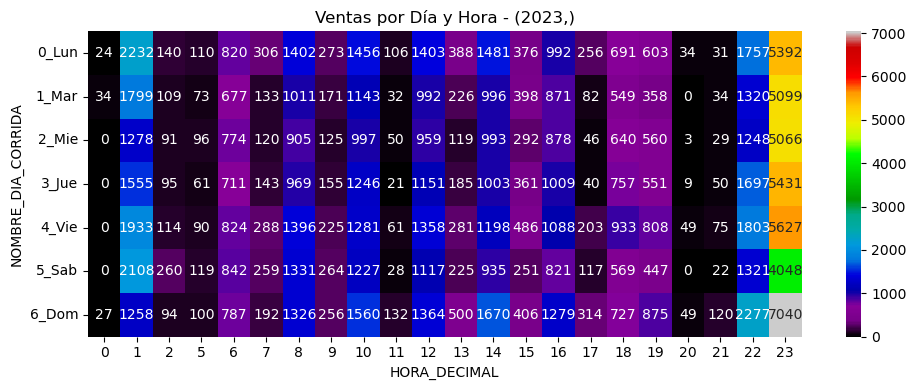

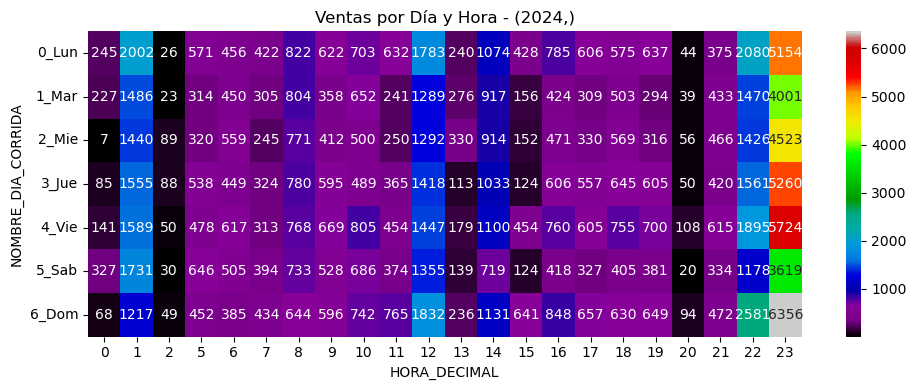

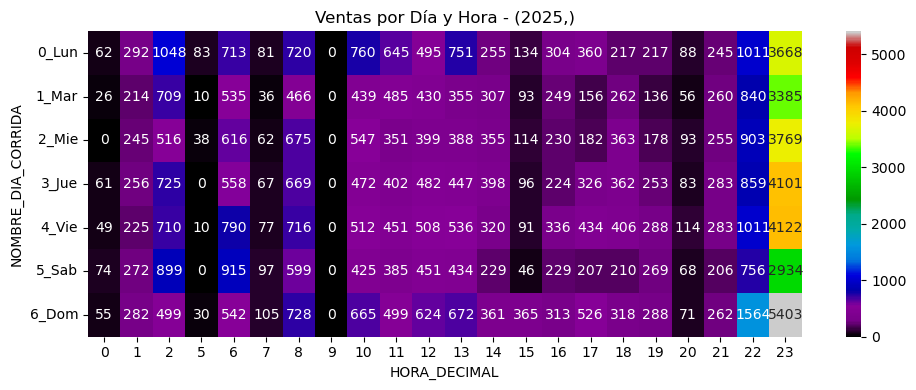

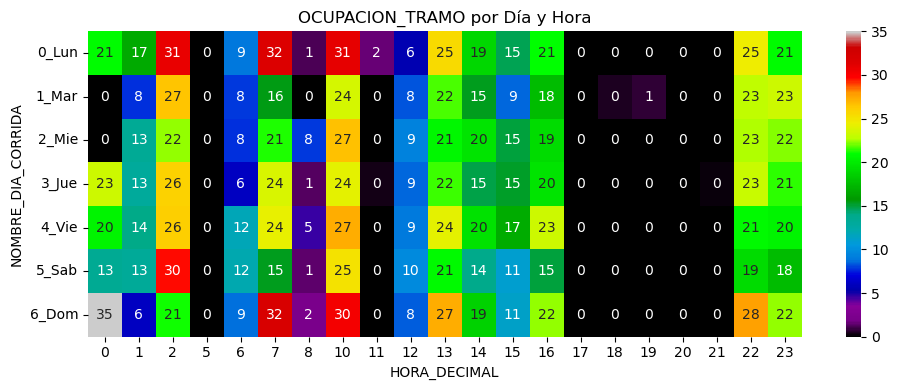

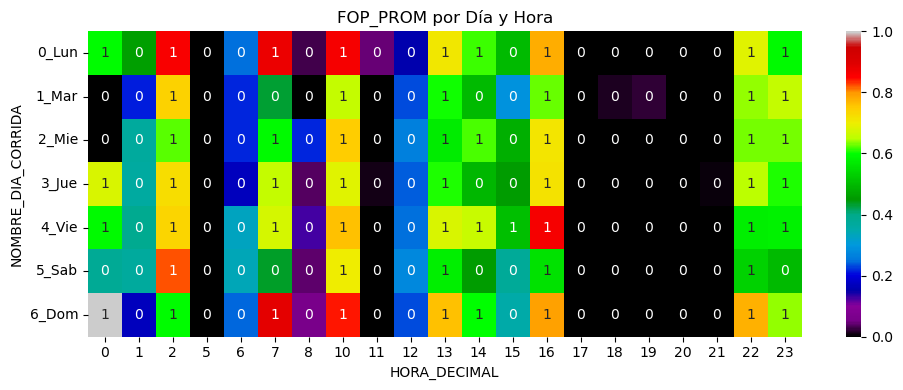

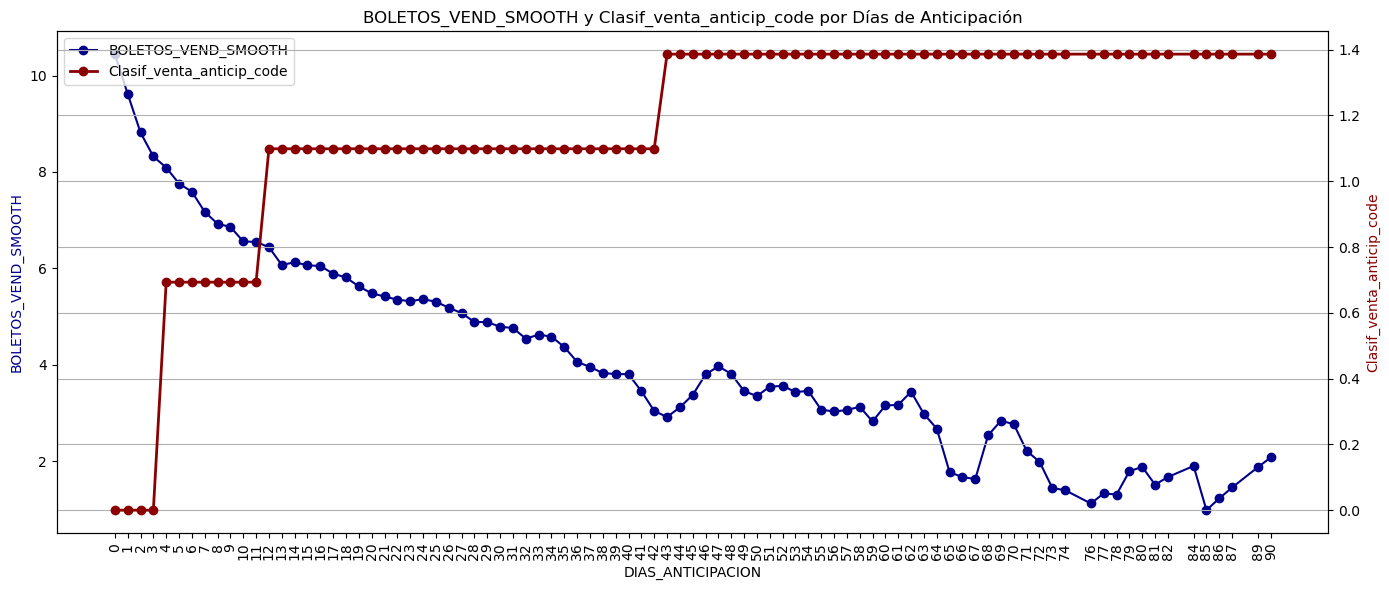

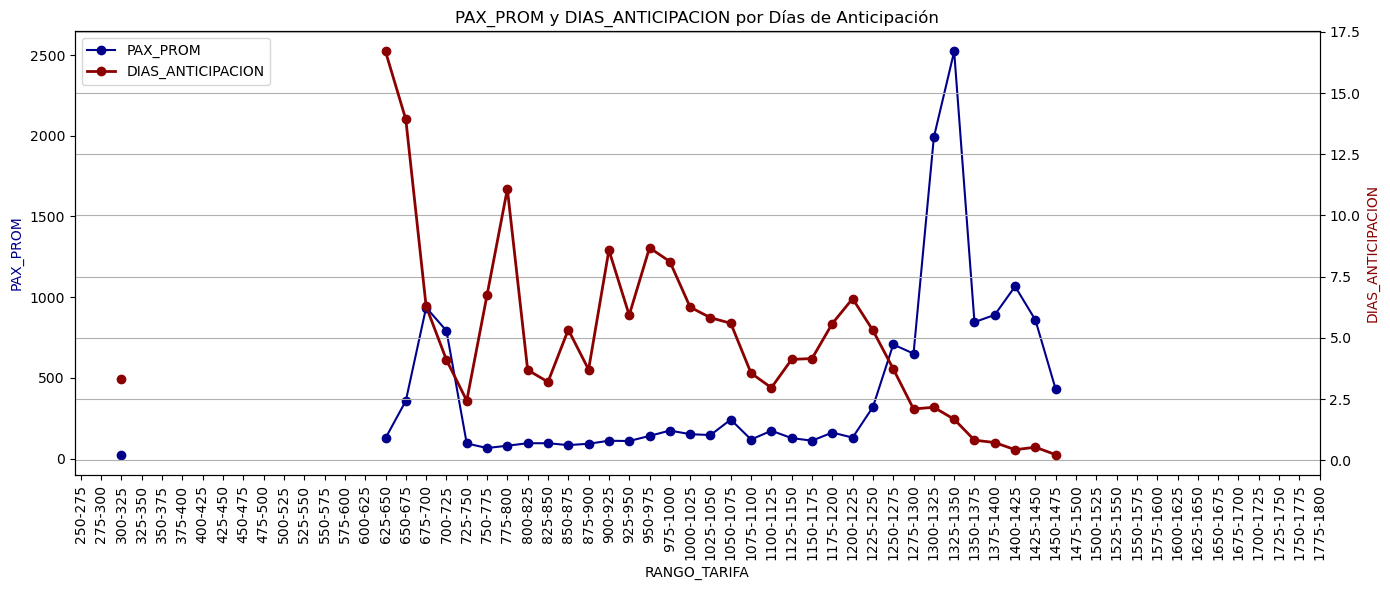

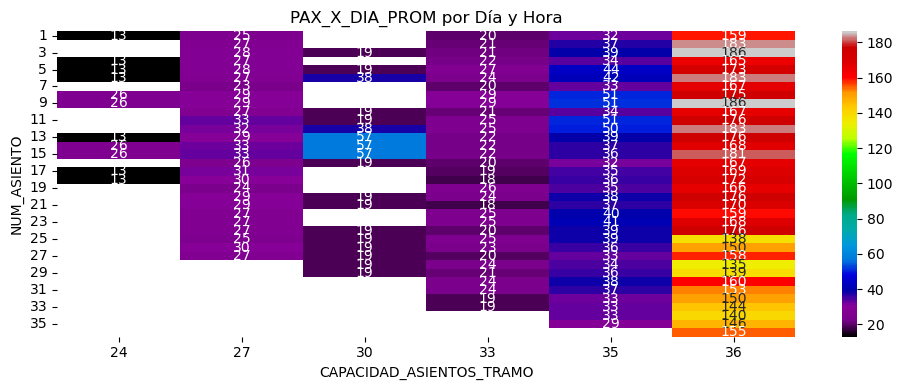

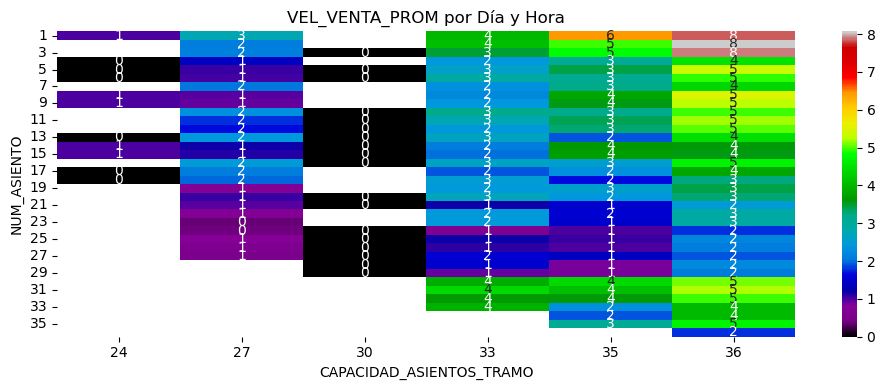

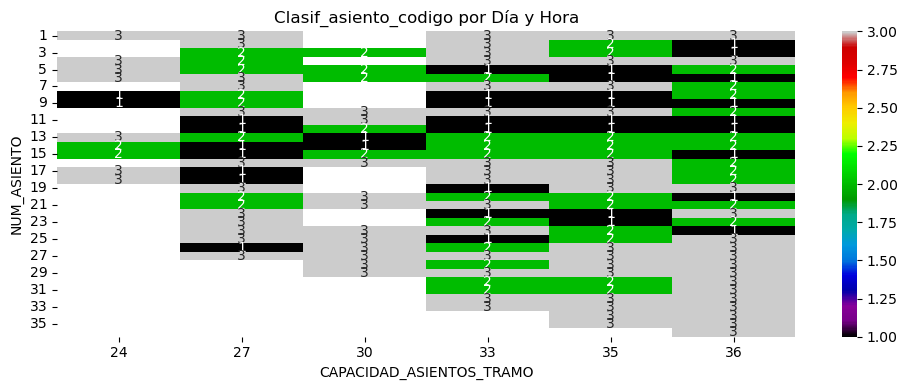

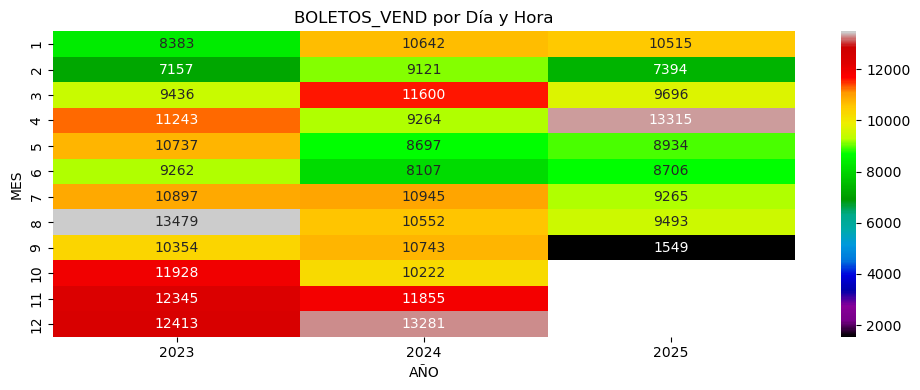

In [4]:
# Visualizaciones
ventas_dia_hora = ventas_x_dia_hora(df_final) 
year_day_hour_plot(ventas_dia_hora, 'AÑO', 'HORA_DECIMAL', 'NOMBRE_DIA_CORRIDA', 'BOLETOS_VEND', aggfun='sum')

day_hour_plot(kpis['ocupacion_promedio'], 'HORA_DECIMAL', 'NOMBRE_DIA_CORRIDA', 'OCUPACION_TRAMO', aggfun='sum')
day_hour_plot(kpis['ocupacion_promedio'], 'HORA_DECIMAL', 'NOMBRE_DIA_CORRIDA', 'FOP_PROM', aggfun='sum')

advance_sales_plot(kpis['venta_anticipada'], 'DIAS_ANTICIPACION', 'BOLETOS_VEND_SMOOTH', 'Clasif_venta_anticip_code', xlog=False, ylog=True)

advance_sales_plot(kpis['boletos_x_tarifa'], 'RANGO_TARIFA', 'PAX_PROM', 'DIAS_ANTICIPACION', xlog=False, ylog=False)

day_hour_plot(kpis['venta_x_asientos'], 'CAPACIDAD_ASIENTOS_TRAMO', 'NUM_ASIENTO', 'PAX_X_DIA_PROM', aggfun='sum')
day_hour_plot(kpis['venta_x_asientos'], 'CAPACIDAD_ASIENTOS_TRAMO', 'NUM_ASIENTO', 'VEL_VENTA_PROM', aggfun='sum')
day_hour_plot(kpis['venta_x_asientos'], 'CAPACIDAD_ASIENTOS_TRAMO', 'NUM_ASIENTO', 'Clasif_asiento_codigo', aggfun='mean')

day_hour_plot(kpis['ventas_por_mes'], 'AÑO', 'MES', 'BOLETOS_VEND', aggfun='sum')

### Ejecutar modelo de elasticidad

# Ejecutar modelo de elasticidad
resultados_elasticidad = ejecutar_modelo(df_final)
print(resultados_elasticidad)